<a href="https://colab.research.google.com/github/AliGreo/Text-Based-Projects/blob/main/Text_classification_LSTM%26Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import keras as K
import numpy as np

In [108]:
class AttentionLayer(K.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()


    def call(self, x):
        self.query = tf.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
        self.keys = tf.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
        self.values = tf.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

        scores = tf.einsum('bij,bkj->bik', self.query, self.keys) / tf.sqrt(tf.cast(self.keys.shape[-1], tf.float32))
        weights = K.layers.Softmax(axis=1)(scores)

        output = tf.einsum('bik,bkj->bij', weights, self.values)

        return output

In [2]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset
import datasets

In [5]:
dataset = load_dataset("imdb", split="train")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [12]:
np.mean(([len(i.split()) for i in dataset['text']]))

233.7872

In [13]:
len(dataset)

25000

In [14]:
data = dataset.to_pandas()
data.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [17]:
sample_data = data.sample(frac=0.4, random_state=42)
sample_data.shape

(10000, 2)

In [37]:
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_dataset(dataset):
    text, target = dataset['text'], dataset['label']
    tokenizer = Tokenizer(oov_token='</UNK>')
    tokenizer.fit_on_texts(text)
    seqs = tokenizer.texts_to_sequences(text)
    seqs_padded = pad_sequences(seqs, padding="post", truncating="post", maxlen=240)
    return tokenizer, seqs_padded, target

tokenizer, seqs_padded, target = process_dataset(sample_data)

In [38]:
train_data, test_data, train_label, test_label = tts(seqs_padded,
                                                         target,
                                                         test_size=0.20,
                                                         shuffle=True,
                                                         random_state=42,
                                                         stratify=target)

In [41]:
vocabs = len(tokenizer.word_index) + 1
vocabs

58749

In [104]:
INPUT_DIM=vocabs
OUTPUT_DIM = 128
LSTM_UNITS = 128
LABELS = 1
ACTIVATION="sigmoid"
BATCH_SIZE = 32
MAX_LEN = 240
LOSS= "binary_crossentropy"
OPTIMIZER=K.optimizers.Adam(learning_rate=0.001)

input_layer = K.layers.Input(shape=(240,))
embedding_layer = K.layers.Embedding(input_dim=vocabs, output_dim=OUTPUT_DIM)(input_layer)
lstm_layer = K.layers.LSTM(LSTM_UNITS, return_sequences=True)(embedding_layer)

attention_layer = K.layers.Attention(use_scale=True)([lstm_layer, lstm_layer])
batch_norm_layer = K.layers.BatchNormalization()(attention_layer)
flatten_layer = K.layers.Flatten()(batch_norm_layer)
dense_layer = K.layers.Dense(128, activation="relu")(flatten_layer)
output_layer = K.layers.Dense(LABELS, activation=ACTIVATION)(dense_layer)

model = K.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])


print(model.summary())

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 240)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_35 (Embedding)  │ (None, 240, 128)       │      7,519,872 │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_35 (LSTM)            │ (None, 240, 128)       │        131,584 │ embedding_35[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_29 (Attention)  │ (None, 240, 128)       │              1 │ lstm_35[0][0],         │
│                           │                        │                │ lstm_35[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 240, 128)       │            512 │ attention_29[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_19 (Flatten)      │ (None, 30720)          │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 128)            │      3,932,288 │ flatten_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 1)              │            129 │ dense_40[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,584,386 (44.19 MB)

 Trainable params: 11,584,130 (44.19 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [105]:
hist = model.fit(train_data,
                 train_label,
                 epochs=20,
                 batch_size=BATCH_SIZE,
                 validation_data=(test_data, test_label))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.5848 - loss: 1.4919 - val_acc: 0.6120 - val_loss: 0.6104
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc: 0.8826 - loss: 0.2858 - val_acc: 0.8190 - val_loss: 0.4192
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - acc: 0.9531 - loss: 0.1298 - val_acc: 0.7930 - val_loss: 0.4911
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - acc: 0.9646 - loss: 0.0979 - val_acc: 0.8440 - val_loss: 0.4939
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - acc: 0.9758 - loss: 0.0650 - val_acc: 0.8500 - val_loss: 0.6174
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc: 0.9819 - loss: 0.0474 - val_acc: 0.8410 - val_loss: 1.2366
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - acc: 0.9768 - loss: 0.0803 - val_acc: 0.8520 - val_loss: 0.6360
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - acc: 0.9902 - loss: 0.0330 - val_acc: 0.8465 - val_loss: 0.6212
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 2

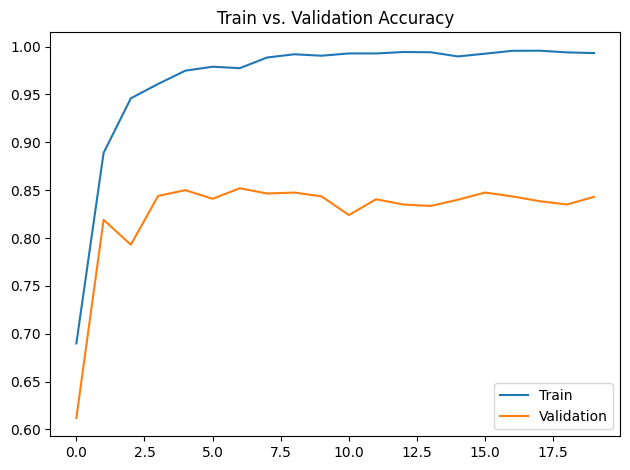

In [106]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label="Train")
plt.plot(hist.history['val_acc'], label="Validation")
plt.title("Train vs. Validation Accuracy")
plt.tight_layout()
plt.legend()
plt.show()

In [107]:
predictions = model.predict(test_data).round()

from sklearn.metrics import classification_report

print(classification_report(predictions, test_label))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1034
         1.0       0.83      0.85      0.84       966

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

